## 日経平均予測
### 翌営業日の日経平均終値に対する単純騰落予測（上がるか／下がるか）、
### および４パターン増減予測（①1%以上 ②0%以上、1%未満　 ③-1%以上、0%未満　 ④-1%超）を行う。

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time

from __future__ import print_function
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.utils import np_utils

from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform
from keras.initializers import orthogonal
from keras.initializers import TruncatedNormal
from keras import optimizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

C:\Users\yt690\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### CSVファイル読み込み

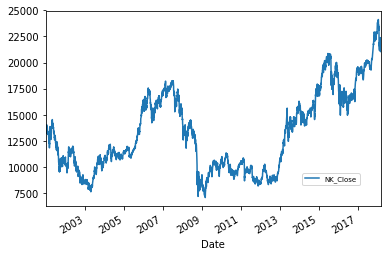

,NK_Close
count,4212.000000
mean,13258.716387
std,3830.598834
min,7054.980000
25%,9999.692500
50%,12241.785000
75%,16313.537500
max,24124.150000


In [2]:
# 学習データの読み込み
df = pd.read_csv('mktdat_nk1.csv',encoding='utf-8',index_col='Date', parse_dates=[0])

#データ確認
df.head() 
df.plot()
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=3, fontsize=7)
plt.show()
df.describe()

### データ加工

In [3]:
#増減率（100＊log（前日比））を計算し、新たな列を追加

for i in range(len(df.columns)):
    use_col = df.columns[i]
    df[use_col] =  100*np.log(df[use_col]/df[use_col].shift())
            
#前日比をとったので、先頭行にNaNが含まれるため、先頭行を削除
df=df.dropna(how='any')

In [4]:
df.describe()

,NK_Close
count,4211.000000
mean,0.010138
std,1.523779
min,-12.111026
25%,-0.728694
50%,0.042793
75%,0.826839
max,13.234585


In [5]:
#日経平均終値の増減率を4パターンに分類
df['NK_Close_P1'] = df['NK_Close'] >=1  
df['NK_Close_P2'] =  (0 == df['NK_Close']) | (0 < df['NK_Close']) & (df['NK_Close']<1)
df['NK_Close_P3'] =  (-1<= df['NK_Close']) & (df['NK_Close']<0)
df['NK_Close_P4'] = df['NK_Close']<-1

df['NK_Close_P1'] = df['NK_Close_P1'].astype(np.int)
df['NK_Close_P2'] = df['NK_Close_P2'].astype(np.int)
df['NK_Close_P3'] = df['NK_Close_P3'].astype(np.int)
df['NK_Close_P4'] = df['NK_Close_P4'].astype(np.int)
df.head()

,NK_Close,NK_Close_P1,NK_Close_P2,NK_Close_P3,NK_Close_P4
Date,,,,,
2001-01-09,-1.871362,0,0,0,1
2001-01-10,-1.315398,0,0,0,1
2001-01-11,-1.739042,0,0,0,1
2001-01-12,1.104920,1,0,0,0
2001-01-15,1.180398,1,0,0,0


In [6]:
# 学習データ
x_data = np.array(df.iloc[:,0:(len(df.columns)-4)].astype(np.float))

# ラベルデータ（増減率４パターン）
y_data = np.array(df.iloc[:,(len(df.columns)-4):].astype(np.float)) 

In [7]:
maxlen = 80              # 入力系列数
n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
print("n_in:",n_in)
n_out = y_data.shape[1]  # ラベルデータ（=出力）の列数
print("n_out:",n_out)
len_seq = x_data.shape[0] - maxlen
print("x_data.shape[0]:",x_data.shape[0])
print("len_seq:",len_seq)

data = []
target = []
for i in range(0, len_seq):
  data.append(x_data[i:i+maxlen, :]) #80個ずつずらして取得
  target.append(y_data[i+maxlen, :])#80個目から取得

print("len(data):",len(data))
x = np.array(data).reshape(len(data), maxlen, n_in)
y = np.array(target).reshape(len(data), n_out)

print(x.shape, y.shape)

n_in: 1
n_out: 4
x_data.shape[0]: 4211
len_seq: 4131
len(data): 4131
(4131, 80, 1) (4131, 4)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                26240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 324       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 26,564
Trainable params: 26,564
Non-trainable params: 0
_________________________________________________________________


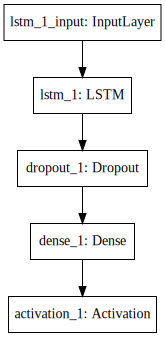

In [8]:
n_hidden = 80     # 出力次元
epochs = 100      # エポック数
batch_size = 10   # ミニバッチサイズ

# ネットワークモデル構築
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape = (None, maxlen, n_in),kernel_initializer = glorot_uniform(seed=1234), recurrent_initializer = orthogonal(gain=1.0, seed=1234), dropout = 0.5, recurrent_dropout = 0.5))
model.add(Dropout(0.5))
model.add(Dense(n_out,kernel_initializer = glorot_uniform(seed=1234)))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer = "RMSprop", metrics = ['accuracy'])

# モデルのサマリを表示
model.summary()
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 3345 samples, validate on 372 samples
Epoch 1/100
3345/3345 [==============================] - 19s - loss: 1.3697 - acc: 0.2981 - val_loss: 1.3573 - val_acc: 0.3091
Epoch 2/100
3345/3345 [==============================] - 18s - loss: 1.3675 - acc: 0.3037 - val_loss: 1.3549 - val_acc: 0.3145
Epoch 3/100
3345/3345 [==============================] - 19s - loss: 1.3630 - acc: 0.3145 - val_loss: 1.3494 - val_acc: 0.3065
Epoch 4/100
3345/3345 [==============================] - 18s - loss: 1.3609 - acc: 0.3058 - val_loss: 1.3482 - val_acc: 0.3226
Epoch 5/100
3345/3345 [==============================] - 18s - loss: 1.3624 - acc: 0.2990 - val_loss: 1.3514 - val_acc: 0.3065
Epoch 6/100
3345/3345 [==============================] - 18s - loss: 1.3557 - acc: 0.3229 - val_loss: 1.3524 - val_acc: 0.3038
Epoch 7/100
3345/3345 [==============================] - 19s - loss: 1.3587 - acc: 0.3070 - val_loss: 1.3457 - val_acc: 0.3118
Epoch 8/100
3345/3345 [==============================] - 20s - l

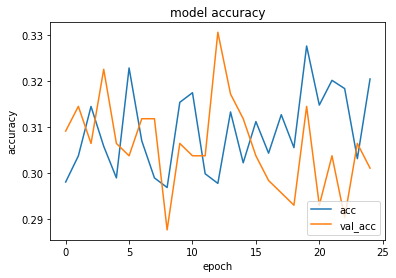

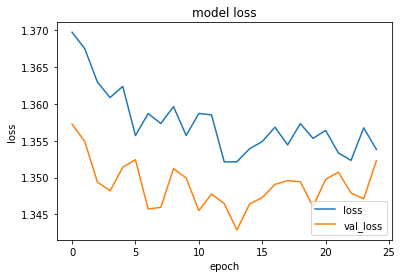

414/414 [==============================] - 0s     
score: [1.3568348383557969, 0.32125604519809503]
識別率（騰落４分類）: 0.32126
識別率（騰落）: 0.54831
Wall time: 8min 16s


In [9]:
%%time

#データを学習用とテスト用に分割 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=1234)         

# 学習
early_stopping = EarlyStopping(patience=10, verbose=1)
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1,shuffle = True, callbacks = [early_stopping], validation_split = 0.1)

# 精度の履歴をプロット
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

# 損失の履歴をプロット
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show()

#テスト
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("score:", score)

#識別率（騰落４分類）
y_pred = model.predict(x_test)
correct = 0
semi_correct = 0
for i in range(len(y_pred)):
  pred = np.argmax(y_pred[i,:])
  tar = np.argmax(y_test[i,:])
  if pred == tar :
    correct += 1
  else :
    if pred+tar == 1 or pred+tar == 5 :
      semi_correct += 1

print("識別率（騰落４分類）: %6.5f" % (1.0 * correct / len(y_pred)))
print("識別率（騰落）: %6.5f" % (1.0 * (correct+semi_correct) / len(y_pred)))